In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google_drive_downloader import GoogleDriveDownloader as gdd

import cv2

import os

import tensorflow as tf

from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, UpSampling2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

from tensorflow.keras.callbacks import TensorBoard

# Barcode Image Segmentation

## Abstract

Barcodes are widely used to localize items on images. Numerous applications are available to find and recognize the barcodes. However they cannot manage cases such as targets with small scale, oclusions, shape deformations, noise and blurring. The most widely solutions require the barcode to be oriented in single directions and may fail in conditions that seem without problems.

This work attempts to solve the problem of barcode localization using a deep learning based segmentation approach.

## Datasets

In [3]:
# Change to the folder where the images datasets are loaded/present and where the 
WORKPLACE_FOLDER = "/tmp"

# Folder to store/read checkpoints for model training
CHECKPOINTS_DIR = "checkpoints"

# Image size for the input
IMAGE_SIZE = (224, 224)

# Image size + channels for the input
INPUT_IMAGE_SIZE = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)

# Execution flags
RESUME_MODELS = True
TRAIN_MODELS = False
SAVE_SIMULATED_MASKS = False

# Folder to write simulated masks
SIMULATED_MASKS_FOLDER = "simulated_masks"

BATCH_SIZE = 32
NUM_EPOCHS = 60

In total five datasets are used - two to train the neural network and three to test.

First three datasets are downloaded from http://artelab.dista.uninsubria.it/downloads/datasets/barcode/medium_barcode_1d/medium_barcode_1d.html (ARTELAB) [[1](#ref_1)]

The masks for the segments containing barcodes were created using the [pyzbar](https://pypi.org/project/pyzbar/pyzbar) library. For this purpose the image was rotated with predefined steps and the obtained from [pyzbar](https://pypi.org/project/pyzbar/pyzbar) points were used to set the required segments.

It has to be noted that the [pyzbar](https://pypi.org/project/pyzbar/pyzbar) did not produced reliable results even for some images that seemed without defects. For this reason not all the images from [ARTELAB](http://artelab.dista.uninsubria.it/downloads/datasets/barcode/medium_barcode_1d/medium_barcode_1d.html) were used. Only the successfully generated masks were applied.

### Dataset 1

Pictures of barcodes taken from devices with autofocus - first subset.
Contains 122 images (originals + masks) with zipped size 38,5 MB 

In [4]:
gdd.download_file_from_google_drive(file_id="18MFEr2iekIojLwEhzswOIyW_Fp8CNQA5",
                                    dest_path=os.path.join(WORKPLACE_FOLDER, "Dataset1.zip"),
                                    unzip=True)

### Dataset 2

Pictures of barcodes taken from devices with autofocus - first subset.
Contains 76 images (originals + masks) with zipped size 124,5 MB

In [5]:
gdd.download_file_from_google_drive(file_id="1SHJi744MZV40Mp38m6RW8PeuQktbEt6u",
                                    dest_path=os.path.join(WORKPLACE_FOLDER, "Dataset2.zip"),
                                    unzip=True)

### Dataset 3

Pictures of barcodes taken from devices without autofocus. Contains 61 images (originals + masks) with zipped size 13,6 MB 

In [6]:
gdd.download_file_from_google_drive(file_id="1ybx4TiciMoQcpVi3fAzZoUOuSg2WPrvI",
                                    dest_path=os.path.join(WORKPLACE_FOLDER, "Dataset3.zip"),
                                    unzip=True)

### Dataset 4

Downloaded from https://github.com/rohrlaf/SlaRle.js/tree/master/Muenster%20BarcodeDB and referenced as Muenster BarodeDB [[2](#ref_2)]. Masks were prepared following the above mentioned procedure with [pyzbar](https://pypi.org/project/pyzbar/pyzbar) 

Contains 863 images (originals + masks) with zipped size 46,9 MB 

In [7]:
gdd.download_file_from_google_drive(file_id="1gfxKTaG7tHDDK5fPQW6PH-Zcbx7KPXzO",
                                    dest_path=os.path.join(WORKPLACE_FOLDER, "Dataset4.zip"),
                                    unzip=True)

### Dataset 5

Downloaded from http://artelab.dista.uninsubria.it/downloads/datasets/barcode/hough_barcode_1d/hough_barcode_1d.html (ARTELAB) [[3](#ref_3)] Referenced as dataset no.2 plain (1d_barcode_extended_plain.zip) contains only the images and the detection masks. Masks had to be adjusted to be grayscale one channel images.

Contains 365 images (originals + masks) with zipped size 37,5 MB

In [8]:
gdd.download_file_from_google_drive(file_id="1rNi26q-iq5Q4BtrIOT-pDSleCtKzw3pk",
                                    dest_path=os.path.join(WORKPLACE_FOLDER, "Dataset5.zip"),
                                    unzip=True)

In [9]:
def get_all_filenames(base_dir):
    """
    Returns the filenames for barcodes and masks
    Assumes the following structure:
    |---base_dir
    | |---Original
    | | |---image1.jpg
    | | |---image2.jpg
    | |---Detection
    | | |---image1.png
    | | |---image2.png
    
    :param base_dir: directories where image databse is stored
    
    """
    
    filenames = {}
    filenames["Original"] = []
    filenames["Detection"] = []
    
    # True if image is to be rotated counter-clockwise by 90 degrees.
    filenames["Rotation"] = []
    
    original_directory = os.path.join(base_dir,"Original")
    detection_directory = os.path.join(base_dir,"Detection")
    for file_name in os.listdir(original_directory):
        if file_name.endswith(".jpg"):
            original_name = os.path.join(original_directory, file_name)
            base_filename=os.path.splitext(file_name)[0]
            detection_name = os.path.join(detection_directory, base_filename + ".png")
            if os.path.exists(detection_name):
                filenames["Rotation"].append(True)
                filenames["Original"].append(original_name)
                filenames["Detection"].append(detection_name)
                filenames["Rotation"].append(False)
                filenames["Original"].append(original_name)
                filenames["Detection"].append(detection_name)
        
    return pd.DataFrame(filenames)

In [10]:
filenames_dataset_1 = get_all_filenames(os.path.join(WORKPLACE_FOLDER, "Dataset1"))
filenames_dataset_2 = get_all_filenames(os.path.join(WORKPLACE_FOLDER, "Dataset2"))
filenames_dataset_3 = get_all_filenames(os.path.join(WORKPLACE_FOLDER, "Dataset3"))
filenames_dataset_4 = get_all_filenames(os.path.join(WORKPLACE_FOLDER, "Dataset4"))
filenames_dataset_5 = get_all_filenames(os.path.join(WORKPLACE_FOLDER, "Dataset5"))

In [11]:
assert(filenames_dataset_1.shape[0] == 244)

In [12]:
assert(filenames_dataset_2.shape[0] == 152)

In [13]:
assert(filenames_dataset_3.shape[0] == 122)

In [14]:
assert(filenames_dataset_4.shape[0] == 1726)

In [15]:
assert(filenames_dataset_5.shape[0] == 730)

## Preparation of images

In [16]:
def preprocess_image(x):
    # Normalize
    x = tf.cast(x, tf.float32) / 255.0

    # 'RGB'->'BGR'
    x = x[..., ::-1]
    return x

def read_and_prepare_image(original_image_filename, mask_image_filename, is_rotated):
    # Get images
    original_image = tf.io.read_file(original_image_filename)
    original_image_decoded = tf.image.decode_jpeg(original_image)
    mask_image = tf.io.read_file(mask_image_filename)
    mask_image_decoded = tf.image.decode_jpeg(mask_image)
    
    # Resize
    original_image_resized = tf.image.resize(original_image_decoded, IMAGE_SIZE)
    mask_image_resized = tf.image.resize(mask_image_decoded, IMAGE_SIZE)
    
    # Rotate
    if is_rotated:
        original_image_resized = tf.image.rot90(original_image_resized)
        mask_image_resized = tf.image.rot90(mask_image_resized)

    original_image_tensor = preprocess_image(original_image_resized)
    mask_image_tensor = preprocess_image(mask_image_resized)
    
    return original_image_tensor, mask_image_tensor

In [17]:
def initialize_tf_dataset(data, should_batch = True, should_repeat = True):
    dataset_initial = tf.data.Dataset.from_tensor_slices((data.Original.values, data.Detection.values, data.Rotation.values))
    dataset_mapped = dataset_initial.map(read_and_prepare_image)
    dataset_shuffled = dataset_mapped.shuffle(buffer_size = len(data))
    
    if should_batch:
        dataset = dataset_shuffled.batch(BATCH_SIZE)
    else:
        dataset = dataset_shuffled.batch(len(data))
        
    if should_repeat:
        dataset = dataset.repeat()
    return dataset

In [18]:
train_data_1 = initialize_tf_dataset(filenames_dataset_4)
train_data_2 = initialize_tf_dataset(filenames_dataset_5)

In [19]:
train_data_map = {
    train_data_1 : "train1",
    train_data_2 : "train2"
}

In [20]:
test_data_1 = initialize_tf_dataset(filenames_dataset_1, should_batch = False, should_repeat = False)
test_data_2 = initialize_tf_dataset(filenames_dataset_2, should_batch = False, should_repeat = False)
test_data_3 = initialize_tf_dataset(filenames_dataset_3, should_batch = False, should_repeat = False)

In [21]:
test_data_map = {
    test_data_1 : "test1",
    test_data_2 : "test2",
    test_data_3 : "test3"
}

In [22]:
for data in train_data_map.keys():
    for batch in data:
        assert(batch[0].shape[0] == BATCH_SIZE)
        assert(batch[0].shape[1] == INPUT_IMAGE_SIZE[0])
        assert(batch[0].shape[2] == INPUT_IMAGE_SIZE[1])
        assert(batch[0].shape[3] == INPUT_IMAGE_SIZE[2])
        assert(batch[1].shape[0] == BATCH_SIZE)
        assert(batch[1].shape[1] == INPUT_IMAGE_SIZE[0])
        assert(batch[1].shape[2] == INPUT_IMAGE_SIZE[1])
        assert(batch[1].shape[3] == 1)
        break

In [23]:
for data, filenames in zip(test_data_map.keys(),
                           [filenames_dataset_1, filenames_dataset_2, filenames_dataset_3]):
    for batch in data:
        assert(batch[0].shape[0] == filenames.shape[0])
        assert(batch[0].shape[1] == INPUT_IMAGE_SIZE[0])
        assert(batch[0].shape[2] == INPUT_IMAGE_SIZE[1])
        assert(batch[0].shape[3] == INPUT_IMAGE_SIZE[2])
        assert(batch[1].shape[0] == filenames.shape[0])
        assert(batch[1].shape[1] == INPUT_IMAGE_SIZE[0])
        assert(batch[1].shape[2] == INPUT_IMAGE_SIZE[1])
        assert(batch[1].shape[3] == 1)
        break

## Model

The models used the architecture inspired from SegNet [[4](#ref_4)] It is a convolutional neural network architecture applied for semantic pixel wise segmentation. It consists of an encoder, decoder and binary classification layers. Decoder maps the low resolution encoder result to input resolution size for pixel wise classification.

The models were separated into two groups - with wide convolution (w) and with narrow convolution (n). They have different count of convolutional layers in order to study the effects of regularization on model performance. The first set of filters is as follows:

* Two wide convolutional layers per encoder/decoder:

In [24]:
def get_model_2lw():
    return Sequential([
        Input(INPUT_IMAGE_SIZE),
        Conv2D(8,(3,3), activation=tf.keras.activations.relu, padding='same'),
        MaxPooling2D((2,2), padding='same'),
        Conv2D(16,(3,3), activation=tf.keras.activations.relu, padding='same'),
        BatchNormalization(),
        MaxPooling2D((2,2), padding='same'),
        Conv2D(16, (3, 3), activation=tf.keras.activations.relu, padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(8, (3, 3), activation=tf.keras.activations.relu, padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(1, (1, 1), activation=tf.keras.activations.relu, padding='same')
    ])

* Three wide convolutional layers per encoder/decoder:

In [25]:
def get_model_3lw():
    return  Sequential([
        Input(INPUT_IMAGE_SIZE),
        Conv2D(8,(3,3), activation=tf.keras.activations.relu, padding='same'),
        MaxPooling2D((2,2), padding='same'),
        Conv2D(16,(3,3), activation=tf.keras.activations.relu, padding='same'),
        MaxPooling2D((2,2), padding='same'),
        Conv2D(32,(3,3), activation=tf.keras.activations.relu, padding='same'),
        BatchNormalization(),
        MaxPooling2D((2,2), padding='same'),
        Conv2D(32, (3, 3), activation=tf.keras.activations.relu, padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(16, (3, 3), activation=tf.keras.activations.relu, padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(8, (3, 3), activation=tf.keras.activations.relu, padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(1, (1, 1), activation=tf.keras.activations.relu, padding='same')
    ])

* Four wide convolutional layers per encoder/decoder:

In [26]:
def get_model_4lw():
    return Sequential([
        Input(INPUT_IMAGE_SIZE),
        Conv2D(8,(3,3), activation=tf.keras.activations.relu, padding='same'),
        MaxPooling2D((2,2), padding='same'),
        Conv2D(16,(3,3), activation=tf.keras.activations.relu, padding='same'),
        MaxPooling2D((2,2), padding='same'),
        Conv2D(32,(3,3), activation=tf.keras.activations.relu, padding='same'),
        MaxPooling2D((2,2), padding='same'),
        Conv2D(64,(3,3), activation=tf.keras.activations.relu, padding='same'),
        BatchNormalization(),
        MaxPooling2D((2,2), padding='same'),
        Conv2D(64, (3, 3), activation=tf.keras.activations.relu, padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(32, (3, 3), activation=tf.keras.activations.relu, padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(16, (3, 3), activation=tf.keras.activations.relu, padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(8, (3, 3), activation=tf.keras.activations.relu, padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(1, (1, 1), activation=tf.keras.activations.relu, padding='same')
    ])

* Five wide convolutional layers per encoder/decoder failed to converge and is not present in this calculation.

In [27]:
model_w_map = {
    get_model_2lw() : "model2lw",
    get_model_3lw() : "model3lw",
    get_model_4lw() : "model4lw",
}

* Two narrow convolutional layers per encoder/decoder:

In [28]:
def get_model_2ln():
    return Sequential([
        Input(INPUT_IMAGE_SIZE),
        Conv2D(4,(3,3), activation=tf.keras.activations.relu, padding='same'),
        MaxPooling2D((2,2), padding='same'),
        Conv2D(8,(3,3), activation=tf.keras.activations.relu, padding='same'),
        BatchNormalization(),
        MaxPooling2D((2,2), padding='same'),
        Conv2D(8, (3, 3), activation=tf.keras.activations.relu, padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(4, (3, 3), activation=tf.keras.activations.relu, padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(1, (1, 1), activation=tf.keras.activations.relu, padding='same')
    ])

* Three narrow convolutional layers per encoder/decoder:

In [29]:
def get_model_3ln():
    return Sequential([
        Input(INPUT_IMAGE_SIZE),
        Conv2D(4,(3,3), activation=tf.keras.activations.relu, padding='same'),
        MaxPooling2D((2,2), padding='same'),
        Conv2D(8,(3,3), activation=tf.keras.activations.relu, padding='same'),
        MaxPooling2D((2,2), padding='same'),
        Conv2D(16,(3,3), activation=tf.keras.activations.relu, padding='same'),
        BatchNormalization(),
        MaxPooling2D((2,2), padding='same'),
        Conv2D(16, (3, 3), activation=tf.keras.activations.relu, padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(8, (3, 3), activation=tf.keras.activations.relu, padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(4, (3, 3), activation=tf.keras.activations.relu, padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(1, (1, 1), activation=tf.keras.activations.relu, padding='same')
    ])

* Four narrow convolutional layers per encoder/decoder:

In [30]:
def get_model_4ln():
    return Sequential([
        Input(INPUT_IMAGE_SIZE),
        Conv2D(4,(3,3), activation=tf.keras.activations.relu, padding='same'),
        MaxPooling2D((2,2), padding='same'),
        Conv2D(8,(3,3), activation=tf.keras.activations.relu, padding='same'),
        MaxPooling2D((2,2), padding='same'),
        Conv2D(16,(3,3), activation=tf.keras.activations.relu, padding='same'),
        MaxPooling2D((2,2), padding='same'),
        Conv2D(32,(3,3), activation=tf.keras.activations.relu, padding='same'),
        BatchNormalization(),
        MaxPooling2D((2,2), padding='same'),
        Conv2D(32, (3, 3), activation=tf.keras.activations.relu, padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(16, (3, 3), activation=tf.keras.activations.relu, padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(8, (3, 3), activation=tf.keras.activations.relu, padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(4, (3, 3), activation=tf.keras.activations.relu, padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(1, (1, 1), activation=tf.keras.activations.relu, padding='same')
    ])

* Five narrow convolutional layers per encoder/decoder:

In [31]:
def get_model_5ln():
    return Sequential([
        Input(INPUT_IMAGE_SIZE),
        Conv2D(4,(3,3), activation=tf.keras.activations.relu, padding='same'),
        MaxPooling2D((2,2), padding='same'),
        Conv2D(8,(3,3), activation=tf.keras.activations.relu, padding='same'),
        MaxPooling2D((2,2), padding='same'),
        Conv2D(16,(3,3), activation=tf.keras.activations.relu, padding='same'),
        MaxPooling2D((2,2), padding='same'),
        Conv2D(32,(3,3), activation=tf.keras.activations.relu, padding='same'),
        MaxPooling2D((2,2), padding='same'),
        Conv2D(64,(3,3), activation=tf.keras.activations.relu, padding='same'),
        BatchNormalization(),
        MaxPooling2D((2,2), padding='same'),
        Conv2D(64, (3, 3), activation=tf.keras.activations.relu, padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(32, (3, 3), activation=tf.keras.activations.relu, padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(16, (3, 3), activation=tf.keras.activations.relu, padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(8, (3, 3), activation=tf.keras.activations.relu, padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(4, (3, 3), activation=tf.keras.activations.relu, padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(1, (1, 1), activation=tf.keras.activations.relu, padding='same')
    ])

In [32]:
model_n_map = {
    get_model_2ln() : "model2ln",
    get_model_3ln() : "model3ln",
    get_model_4ln() : "model4ln",
    get_model_5ln() : "model5ln",
}

The count of training steps per epoch is set as follows as the whole datasets are used for training:

In [33]:
steps_per_epoch_train_1 = round(len(filenames_dataset_4) * 1.0 / BATCH_SIZE)
steps_per_epoch_train_2 = round(len(filenames_dataset_5) * 1.0 / BATCH_SIZE)

In [34]:
steps_per_epoch_train_1

54

In [35]:
steps_per_epoch_train_2

23

In [36]:
steps_per_epoch_map = {
    train_data_1 : steps_per_epoch_train_1,
    train_data_2 : steps_per_epoch_train_2
}

In [37]:
if not os.path.exists(CHECKPOINTS_DIR):
    os.makedirs(CHECKPOINTS_DIR)

In [38]:
fitted_models = {}
train_evaluations = {}
test_evaluations = {}

for train_item in train_data_map.items():
    train_data = train_item[0]
    train_name = train_item[1]
    
    fitted_models_train_set = {}
    test_evaluations_train_set = {}
    train_evaluations_train_set = {}
    
    for model_item in {**model_w_map , **model_n_map}.items():
        model_name = model_item[1]
        
        model = clone_model(model_item[0])
        
        checkpoint_basename = train_name + "_" + model_name
        checkpoint_path = os.path.join(CHECKPOINTS_DIR,checkpoint_basename)
        
        model_weights_file = os.path.join(checkpoint_path, "cp.ckpt")
        log_path = os.path.join(checkpoint_path, "log")
        
        # Callback to save the model's weights
        cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=model_weights_file,
                                                         save_weights_only=True)  

        print(checkpoint_path)
        
        needs_training = True
        if os.path.exists(checkpoint_path) and RESUME_MODELS:
            model.load_weights(model_weights_file).expect_partial()
            needs_training = False            
        
        # Default parameters prove to be sufficient for proper convergence
        model.compile(optimizer=Adam(), loss=MeanSquaredError())
        
        if TRAIN_MODELS or needs_training:
            history = model.fit(train_data,
                                epochs = NUM_EPOCHS,
                                steps_per_epoch = steps_per_epoch_map[train_data],
                                callbacks = [TensorBoard(log_dir=log_path),
                                             cp_callback]
                               )
        
        train_evaluations_train_set[model_name] = \
        model.evaluate(train_data, steps = steps_per_epoch_map[train_data])
        
        test_evaluations_test_set = {}
        for test_item in test_data_map.items():
            test_data = test_item[0]
            test_evaluations_test_set[test_data] = model.evaluate(test_data)
        
        fitted_models_train_set[model_name] = model
        test_evaluations_train_set[model_name] = test_evaluations_test_set
        
    fitted_models[train_data] = fitted_models_train_set
    test_evaluations[train_data] = test_evaluations_train_set
    train_evaluations[train_data] = train_evaluations_train_set


checkpoints/train1_model2lw
1/1 [==============================] - 1s 1s/step - loss: 0.0176
checkpoints/train1_model3lw
1/1 [==============================] - 1s 1s/step - loss: 0.0160
checkpoints/train1_model4lw
1/1 [==============================] - 1s 1s/step - loss: 0.0170
checkpoints/train1_model2ln
1/1 [==============================] - 1s 1s/step - loss: 0.0160
checkpoints/train1_model3ln
1/1 [==============================] - 1s 1s/step - loss: 0.0162
checkpoints/train1_model4ln
1/1 [==============================] - 1s 1s/step - loss: 0.0150
checkpoints/train1_model5ln
1/1 [==============================] - 1s 1s/step - loss: 0.0131
checkpoints/train2_model2lw
1/1 [==============================] - 1s 1s/step - loss: 0.0063
checkpoints/train2_model3lw
1/1 [==============================] - 1s 1s/step - loss: 0.0076
checkpoints/train2_model4lw
1/1 [==============================] - 1s 1s/step - loss: 0.0073
checkpoints/train2_model2ln
1/1 [==============================] - 1s 

Sanity check to verify the models were properly set.

In [39]:
for train_item in train_data_map.items():
    train_data = train_item[0]
    print(train_item[1])
    for model_item in model_w_map.items():
        print(model_item[1])
        model = fitted_models[train_data][model_item[1]]
        model.evaluate(train_data, steps = steps_per_epoch_map[train_data])
    print()
    for model_item in model_n_map.items():
        print(model_item[1])
        model = fitted_models[train_data][model_item[1]]
        model.evaluate(train_data, steps = steps_per_epoch_map[train_data])
    print()     
    print()

train1
model2lw
54/54 [==============================] - 11s 205ms/step - loss: 0.0059
model3lw
54/54 [==============================] - 11s 212ms/step - loss: 0.0044
model4lw
54/54 [==============================] - 12s 220ms/step - loss: 0.0030

model2ln
54/54 [==============================] - 10s 179ms/step - loss: 0.0085
model3ln
54/54 [==============================] - 10s 185ms/step - loss: 0.0055
model4ln
54/54 [==============================] - 10s 188ms/step - loss: 0.0045
model5ln
54/54 [==============================] - 10s 190ms/step - loss: 0.0026


train2
model2lw
23/23 [==============================] - 5s 196ms/step - loss: 0.0098
model3lw
23/23 [==============================] - 5s 206ms/step - loss: 0.0062
model4lw
23/23 [==============================] - 5s 215ms/step - loss: 0.0031

model2ln
23/23 [==============================] - 4s 185ms/step - loss: 0.0223
model3ln
23/23 [==============================] - 4s 186ms/step - loss: 0.0073
model4ln
23/23 [===========

In [40]:
model_test_scores_map = {
    test_data_1 : "Test Score 1",
    test_data_2 : "Test Score 2",
    test_data_3 : "Test Score 3"
}

In [41]:
model_train_scores_map = {
    train_data_1 : "Train Data 1",
    train_data_2 : "Train Data 2"
}

In [42]:
def create_model_scores(train_data, model_map):
    model_scores = {}
    model_scores["Train Data"] = []
    model_scores["Model"] = []
    model_scores["Train Score"] = []
    model_scores["Test Score 1"] = []
    model_scores["Test Score 2"] = []
    model_scores["Test Score 3"] = []

    for model_item in model_map.items():
        model_scores["Train Data"].append(model_train_scores_map[train_data])
        model_scores["Model"].append(model_item[1])
        model_scores["Train Score"].append(train_evaluations[train_data][model_item[1]])
        for test_item in test_data_map.items():
            test_data = test_item[0]
            evaluation = test_evaluations[train_data][model_item[1]][test_data]
            model_scores[model_test_scores_map[test_data]].append(evaluation)     
    
    return pd.DataFrame(model_scores)    

First train set scores for the wide convolutional layer models

In [43]:
create_model_scores(train_data_1, model_w_map)

,Train Data,Model,Train Score,Test Score 1,Test Score 2,Test Score 3
0,Train Data 1,model2lw,0.005941,0.068149,0.037784,0.017575
1,Train Data 1,model3lw,0.004435,0.061945,0.028210,0.015983
2,Train Data 1,model4lw,0.003047,0.057595,0.028425,0.016955


First train set scores for the narrow convolutional layer models

In [44]:
create_model_scores(train_data_1, model_n_map)

,Train Data,Model,Train Score,Test Score 1,Test Score 2,Test Score 3
0,Train Data 1,model2ln,0.008530,0.065537,0.028444,0.015953
1,Train Data 1,model3ln,0.005502,0.061433,0.028468,0.016208
2,Train Data 1,model4ln,0.004514,0.047457,0.023913,0.015039
3,Train Data 1,model5ln,0.002647,0.034251,0.021288,0.013139


Second train set scores for the wide convolutional layer models

In [45]:
create_model_scores(train_data_2, model_w_map)

,Train Data,Model,Train Score,Test Score 1,Test Score 2,Test Score 3
0,Train Data 2,model2lw,0.009865,0.015484,0.013720,0.006260
1,Train Data 2,model3lw,0.006216,0.014134,0.013086,0.007609
2,Train Data 2,model4lw,0.003054,0.011455,0.012116,0.007313


Second train set scores for the narrow convolutional layer models

In [46]:
create_model_scores(train_data_2, model_n_map)

,Train Data,Model,Train Score,Test Score 1,Test Score 2,Test Score 3
0,Train Data 2,model2ln,0.022372,0.024901,0.023235,0.009399
1,Train Data 2,model3ln,0.007326,0.015069,0.013753,0.006137
2,Train Data 2,model4ln,0.004131,0.012538,0.012194,0.007207
3,Train Data 2,model5ln,0.003882,0.013514,0.012667,0.011890


It can be seen that for the wide convolutional layers the accuracy of the training improves with the count of layers. The same is the general trend for test scoring. However for the case with 5 convolution layers the performace deteriorated and scoring failed to converge. So for both models it can be concluded that the 4 layers models provides the best predictions. 

The wide convolution models trained with the second dataset produce several times better accuracy than ones trained with the first dataset.

The models with the narrow convolutional networks steadily improve their training scores with the count of layers. At 5 layers the train scores are better than the wide conolutional models. 

The test scores are slightly better for the narrow layer model. The models trained with the second dataset here also have the best performance. However in general the best performance depends on the used for testing layer.

It can be concluded that the best model for predicting for the first and second dataset (images taken with autofocus) is the model4lw. For the third dataset (images taken without autofocus) the model4ln performs slighly better than model4lw.

This it can be concluded that wide convolutional layer model with four convolutional layers per encoder/decoder has the best performance.

It has to be noted that the second training dataset (ARTELAB) [3]  has barcode images with much more diverse orientations than the first training dataset Muenster BarodeDB [2]. Also the masks for the first dataset are better prepared and take into account the areas where the barcode is not clearly seen. This could be the reason why the models trained with the second train dataset perform better.

In [47]:
best_model_id = "model4lw"
best_model_data = train_data_2
best_model = fitted_models[best_model_data][best_model_id]

In [48]:
def create_mask(model, image_filename, mask_filename, segment_filename = None):

    original_image = tf.io.read_file(image_filename)
    decoded_image = tf.image.decode_jpeg(original_image)

    # Resize and normalize
    MASK_SIZE =(decoded_image.shape[0], decoded_image.shape[1])
    resized_image = tf.image.resize(decoded_image, IMAGE_SIZE)

    tf_image = preprocess_image(resized_image)

    images_to_model = tf.Variable([tf_image])
    predicted_images = model.predict(images_to_model)
    predicted_image = predicted_images[0]

    scaled_predicted_image = predicted_image * 255
    predicted_image_u8 = tf.saturate_cast(scaled_predicted_image, tf.uint8)

    mask_image = predicted_image_u8.numpy()
    
    mask_resized = cv2.resize(mask_image, (MASK_SIZE[1], MASK_SIZE[0]), interpolation=cv2.INTER_AREA)
    
    cv2.imwrite(mask_filename, mask_resized)
    
    if segment_filename is None:
        return
    
    # Prepare grayscale initial image to present segmentation
    original_image_gray = cv2.imread(image_filename, cv2.IMREAD_GRAYSCALE)
    original_image_segment = cv2.cvtColor(original_image_gray, cv2.COLOR_GRAY2RGB)
    
    # Prepare segmented predicted mask image
    predicted_mask_image_color = cv2.cvtColor(mask_resized, cv2.COLOR_GRAY2RGB)
    predicted_mask_image_color[:, :, 0] = 0
    predicted_mask_image_color[:, :, 2] = 0
    predicted_mask_segmented_image = \
        cv2.addWeighted(original_image_segment, 0.5, predicted_mask_image_color, 0.5, 0.0)
    
    cv2.imwrite(segment_filename, predicted_mask_segmented_image)

In [49]:
test_data_filenames_map = {
    test_data_1 : filenames_dataset_1,
    test_data_2 : filenames_dataset_2,
    test_data_3 : filenames_dataset_3
}

In [50]:
if SAVE_SIMULATED_MASKS:
    for test_item in test_data_map.items():
            test_data = test_item[0]
            filenames = test_data_filenames_map[test_data].Original
            filenames = filenames.drop_duplicates()
            
            output_path = os.path.join(SIMULATED_MASKS_FOLDER,
                           train_data_map[best_model_data] + "_" + best_model_id,
                           test_item[1])
            
            if not os.path.exists(output_path):
                os.makedirs(output_path)
            
            for full_filename in filenames:
                base_filename = os.path.splitext(os.path.basename(full_filename))[0]
                mask_name = base_filename + "_mask.png"
                segment_name = base_filename + "_segment.png"
                
                mask_path = os.path.join(output_path, mask_name)
                segment_path = os.path.join(output_path, segment_name)
                
                create_mask(best_model, full_filename, mask_path, segment_path)               


In [51]:
def draw_masks(model, image_filename, mask_filename):

    fig, plot_grid = plt.subplots(1, 3,  figsize=(12, 18))
    original_mask_image = cv2.imread(mask_filename, cv2.IMREAD_GRAYSCALE)

    original_image = tf.io.read_file(image_filename)
    decoded_image = tf.image.decode_jpeg(original_image)
    
    # Draw initial image
    plot_grid[0].set_title("Original Image")
    plot_grid[0].imshow(decoded_image)
    
    # Prepare grayscale initial image to present segmentation
    original_image_gray = cv2.imread(image_filename, cv2.IMREAD_GRAYSCALE)
    original_image_segment = cv2.cvtColor(original_image_gray, cv2.COLOR_GRAY2RGB)
    
    # Resize and normalize
    MASK_SIZE =(decoded_image.shape[0], decoded_image.shape[1])
    resized_image = tf.image.resize(decoded_image, IMAGE_SIZE)

    tf_image = preprocess_image(resized_image)

    images_to_model = tf.Variable([tf_image])
    predicted_images = model.predict(images_to_model)
    predicted_image = predicted_images[0]

    scaled_predicted_image = predicted_image * 255
    predicted_image_u8 = tf.saturate_cast(scaled_predicted_image, tf.uint8)
    
    mask_image = predicted_image_u8.numpy()
    mask_resized = cv2.resize(mask_image, (MASK_SIZE[1], MASK_SIZE[0]), interpolation=cv2.INTER_AREA)
    
    # Prepare segmented predicted mask image
    predicted_mask_image_color = cv2.cvtColor(mask_resized, cv2.COLOR_GRAY2RGB)
    predicted_mask_image_color[:, :, 0] = 0
    predicted_mask_image_color[:, :, 2] = 0
    predicted_mask_segmented_image = \
        cv2.addWeighted(original_image_segment, 0.5, predicted_mask_image_color, 0.5, 0.0)
    
    # Draw predicted mask image
    plot_grid[1].set_title("Predicted Mask")
    plot_grid[1].imshow(predicted_mask_segmented_image, cmap='gray')

    # Prepare segmented original mask image
    original_mask_image_color = cv2.cvtColor(original_mask_image, cv2.COLOR_GRAY2RGB)
    original_mask_image_color[:, :, 0] = 0
    original_mask_image_color[:, :, 2] = 0
    original_mask_segmented_image = \
        cv2.addWeighted(original_image_segment, 0.5, original_mask_image_color, 0.5, 0.0)
    
    # Draw original mask image
    plot_grid[2].set_title("Actual Mask")
    plot_grid[2].imshow(original_mask_segmented_image)

Typical cases for successfull mask predictions are shown below. It has to be noted that the masks of the test datasets are not used in training.

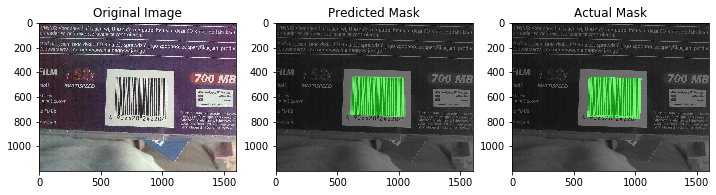

In [52]:
draw_masks(best_model, filenames_dataset_1.Original[0], filenames_dataset_1.Detection[0])    

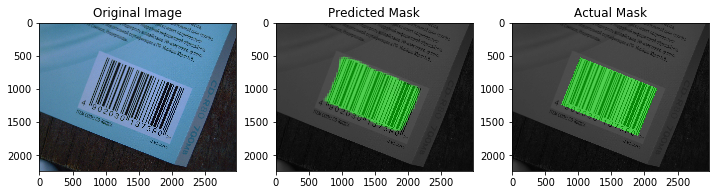

In [53]:
draw_masks(best_model, filenames_dataset_2.Original[0], filenames_dataset_2.Detection[0])

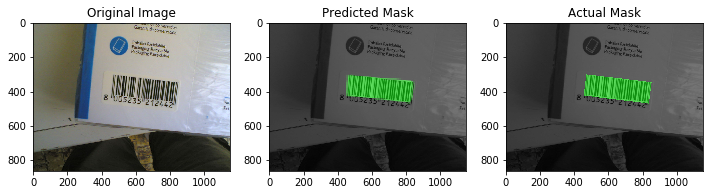

In [54]:
draw_masks(best_model, filenames_dataset_3.Original[0], filenames_dataset_3.Detection[0])

Here are some cases of failures, which are mostly in test set 3 (images taken without autofocus):

In [55]:
dataset3_originals_path = os.path.join(WORKPLACE_FOLDER, "Dataset3", "Original")
dataset3_detections_path = os.path.join(WORKPLACE_FOLDER, "Dataset3", "Detection")

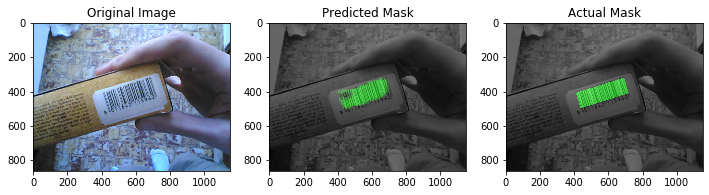

In [56]:
draw_masks(best_model,
           os.path.join(dataset3_originals_path, "Foto(686).jpg"),
           os.path.join(dataset3_detections_path, "Foto(686).png"))

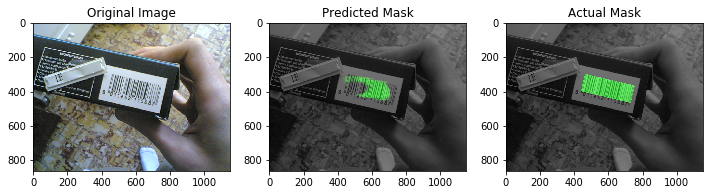

In [57]:
draw_masks(best_model,
           os.path.join(dataset3_originals_path, "Foto(692).jpg"),
           os.path.join(dataset3_detections_path, "Foto(692).png"))

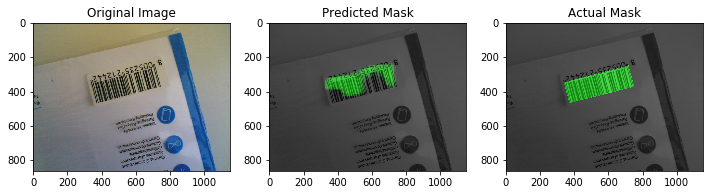

In [58]:
draw_masks(best_model,
           os.path.join(dataset3_originals_path, "Foto(794).jpg"),
           os.path.join(dataset3_detections_path, "Foto(794).png"))

## Conclusions

* Training with different barcode orientation improves segmentation accuracy. It is expected that the accuracy will increase with increased different rotations of training images applied.
* The mask quality affects the accuracy of segmentations. The better the mask covers the barcode the better segmentation is successfull.
* Accuracy is improved by applying more convolutional filters.
* Accuracy increases with the number of convolutional layers, until the model fails to converge.
* Accuarcy of segmentation fails on blurred images.
* In most of the cases the model succeeds in finding proper segmentation of the images.

## References

<a id='ref_1'></a>
1. Alessandro Zamberletti, Ignazio Gallo, Moreno Carullo and Elisabetta Binaghi "Neural Image Restoration For Decoding 1-D Barcodes Using Common Camera Phones" Computer Vision, Imaging and Computer Graphics. Theory and Applications, Springer Berlin Heidelberg, 2011

<a id='ref_2'></a>
2. S. Wachenfeld, S. Terlunen, X.Jiang  "Robust recognition of 1-d barcodes using camera phones.""
In Proceedings of the 2008 19th International Conference on Pattern Recognition, Tampa, FL, USA,
8–11 December 2008; pp. 1–4.

<a id='ref_3'></a>
3. Alessandro Zamberletti, Ignazio Gallo and Simone Albertini "Robust Angle Invariant 1D Barcode Detection" Proceedings of the 2nd Asian Conference on Pattern Recognition (ACPR), Okinawa, Japan, 2013

<a id='ref_4'></a>
4. V. Badrinarayanan, A. Kendall and R. Cipolla, "SegNet: A Deep Convolutional Encoder-Decoder Architecture for Image Segmentation," in IEEE Transactions on Pattern Analysis and Machine Intelligence, vol. 39, no. 12, pp. 2481-2495, 1 Dec. 2017.